# Github\
https://github.com/Credioni/COMP.CS.530-Fine-Tuning-LLMs/tree/main/excercise_5

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step 1 - Install Required Libraries

In [2]:
# ⚠️ Adding pynvml
!pip install -q -U pynvml bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.3/318.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   

In [3]:
# The bitsandbytes library is a lightweight Python wrapper around CUDA custom functions,
# in particular 8-bit optimizers, matrix multiplication (LLM.int8())
# and 8 & 4-bit quantization functions.
import bitsandbytes
import transformers

# State-of-the-art Parameter-Efficient Fine-Tuning (PEFT) methods
import peft

# Accelerate was created for PyTorch users who like to write the training loop
# of PyTorch models but are reluctant to write and maintain the boilerplate code
# needed to use multi-GPUs/TPU/fp16.
import accelerate
import datasets
import scipy

# einops - Flexible and powerful tensor operations for readable and reliable code.
import einops

# Evaluate is a library that makes evaluating and comparing models
# and reporting their performance easier and more standardized - part of HF.
import evaluate

# TRL is a cutting-edge library designed for post-training foundation models using advanced techniques like
# Supervised Fine-Tuning (SFT), Proximal Policy Optimization (PPO),
# and Direct Preference Optimization (DPO).
import trl

# This package is designed to replicate perl results. It implements:
# -ROUGE-N (N-gram) scoring
# -ROUGE-L (Longest Common Subsequence) scoring
# -Text normalization
# -Bootstrap resampling for confidence interval calculation
# -Optional Porter stemming to remove plurals and word suffixes such as (ing, ion, ment).
import rouge_score

print("BitsAndBytes version:", bitsandbytes.__version__)
print("Transformers version:", transformers.__version__)
print("PEFT version:", peft.__version__)
print("Accelerate version:", accelerate.__version__)
print("Datasets version:", datasets.__version__)
print("Scipy version:", scipy.__version__)
print("Einops version:", einops.__version__)
print("Evaluate version:", evaluate.__version__)
print("TRL version:", trl.__version__)
# Does not contain version information
#print("Rouge Score version:", rouge_score.__version__)

BitsAndBytes version: 0.45.2
Transformers version: 4.48.3
PEFT version: 0.14.0
Accelerate version: 1.3.0
Datasets version: 3.3.0
Scipy version: 1.15.1
Einops version: 0.8.1
Evaluate version: 0.4.3
TRL version: 0.15.0


In [4]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [5]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) n


In [6]:
from pynvml import *

def print_gpu_utilization():
    """Printing GPU memory occupied"""
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

# Step 2 - Load the Dataset from hugging face()

In [7]:
# https://huggingface.co/datasets/neil-code/dialogsum-test
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)
dataset

README.md:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/441k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/447k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1999 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/499 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/499 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1999
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
})

In [8]:
row = dataset['train'][0]
print(row.keys())

for key in row.keys():
  print(key + " :", row[key], sep="\n")

dict_keys(['id', 'dialogue', 'summary', 'topic'])
id :
train_0
dialogue :
#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?
#Person2#: I found it would be a good idea to get a check-up.
#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.
#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?
#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.
#Person2#: Ok.
#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?
#Person2#: Yes.
#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.
#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.
#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.
#Person2#: Ok, thanks do

# Step 3 - Create Bitsandbytes Configuration

In [9]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

# Step 4 - Load the Pre-Trained Model

In [10]:
#model_name='microsoft/phi-2'
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device_map,
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_auth_token=True
)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

# Step 5 - Tokenization

## Why Left padding and not right padding?
In decoder-only model architectures, the output of the model is a continuation of the model input.

For example, input: I love apple [pad] [pad]. The output of the model will contain the input and add additional output information.

For example, output: I love apple [pad] [pad],because it is delicious.

This would result in [pad] being stuck in the middle of the text. It is very bad for the model to process text. If we use left-padding, the output of this model will be

output : [pad] [pad] i love apple,because it is delicious.

Such complete semantic information is continuous.

In [11]:
# https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    padding_side="left", # <-----
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [12]:
print_gpu_utilization()

GPU memory occupied: 2577 MB.


In [13]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    # add_bos_token controls whether to add a beginning-of-sequence (BOS) token to the tokenized input.
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

def gen(model, p, maxlen=100, sample=True):
    toks = eval_tokenizer(p, return_tensors="pt")
    res = model.generate(
        **toks.to("cuda"),
        max_new_tokens=maxlen,
        do_sample=sample,
        num_return_sequences=1,
        temperature=0.1,
        num_beams=1,
        top_p=0.95,
      ).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

# Step 6 - Test the Model with Zero-Shot Inference
- Run a few samples to see the base model's performance before fine-tuning.


In [14]:
%%time
from transformers import set_seed
seed = 42
set_seed(seed)

#Run a few samples to see the base model's performance before fine-tuning
for index in [10, 1, 2]:
  index = 10

  prompt = dataset['test'][index]['dialogue']
  summary = dataset['test'][index]['summary']

  formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
  res = gen(original_model, formatted_prompt, 100,)
  #print(res[0])
  output = res[0].split('Output:\n')[1]

  dash_line = '-'.join('' for x in range(100))
  print(dash_line)
  print(f'INPUT PROMPT:\n{formatted_prompt}')
  print(dash_line)
  print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
  print(dash_line)
  print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

# Step 7 - Pre-process the Dataset

In [15]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

In [16]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """Tokenizing a batch"""
    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
    )

In [17]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [19]:
print_gpu_utilization()

GPU memory occupied: 2665 MB.


In [18]:
# ## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(train_dataset)

Found max lenth: 131072
131072
Preprocessing dataset...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1999 [00:00<?, ? examples/s]

Preprocessing dataset...


Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Filter:   0%|          | 0/499 [00:00<?, ? examples/s]

Shapes of the datasets:
Training: (1999, 3)
Validation: (499, 3)
Dataset({
    features: ['text', 'input_ids', 'attention_mask'],
    num_rows: 1999
})


# Step 8 - Prepare the Model for QLoRA

In [22]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0

    for _, param in model.named_parameters():
        all_model_params += param.numel()
        # Checking if parameter requires gradient for gradient decent..
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params:_}\
             \nall model parameters: {all_model_params:_}\npercentage of \
             trainable model parameters: {100 * trainable_model_params / all_model_params:_.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 466_834_944             
all model parameters: 1_121_990_144
percentage of              trainable model parameters: 41.61%


In [23]:
print(original_model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=1536, out_features=1536, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear4bit(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1536,), eps

# Step 9 - Set Up PEFT for Fine-Tuning

In [24]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

In [25]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 5_963_776             
all model parameters: 1_127_953_920
percentage of              trainable model parameters: 0.53%


In [26]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    warmup_steps=1,
    per_device_train_batch_size=4,  # ✅ Increased for better GPU usage - Lowering
    gradient_accumulation_steps=2,  # ✅ Reduced for speed
    max_steps=500, # 👈
    learning_rate=2e-4,
    optim="paged_adamw_8bit",
    logging_steps=50,  # 👈✅ Logs less often
    save_strategy="steps",
    save_steps=100,  # ✅ Saves less often
    evaluation_strategy="steps",
    eval_steps=50,  # 👈 ✅ Evaluates less often
    do_eval=True,
    gradient_checkpointing=False,  # ✅ Disabled for speed
    fp16=True,  # ✅ Enables mixed precision
    report_to="none",
    overwrite_output_dir=True,
    group_by_length=True,
)

peft_model.config.use_cache = False

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Step 10 - Train PEFT Adapter

In [27]:
peft_training_args.device
peft_trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss
50,2.150600,1.893169
100,1.820300,1.832318
150,1.748200,1.816289
200,1.741900,1.802178
250,1.807900,1.792750
300,1.769000,1.785891
350,1.775700,1.780281
400,1.753900,1.776504
450,1.785600,1.774255
500,1.772800,1.775169


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 w

TrainOutput(global_step=500, training_loss=1.8125864715576172, metrics={'train_runtime': 422.1479, 'train_samples_per_second': 4.738, 'train_steps_per_second': 1.184, 'total_flos': 4959050439260160.0, 'train_loss': 1.8125864715576172, 'epoch': 1.0})

# Step 11 - Evaluate the Model Qualitatively


In [28]:
from huggingface_hub import notebook_login
#notebook_login()  # Enter your HF token

# Upload Model & Tokenizer
peft_model.push_to_hub("Credioni/ds-r1-1.5B-dialogsum-finetuned")
tokenizer.push_to_hub("Credioni/ds-r1-1.5B-dialogsum-finetuned")

adapter_model.safetensors:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Credioni/ds-r1-1.5B-dialogsum-finetuned/commit/d1d9eb4d7857755d535057a430ba9e1b7d12321c', commit_message='Upload tokenizer', commit_description='', oid='d1d9eb4d7857755d535057a430ba9e1b7d12321c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Credioni/ds-r1-1.5B-dialogsum-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='Credioni/ds-r1-1.5B-dialogsum-finetuned'), pr_revision=None, pr_num=None)

In [29]:
print_gpu_utilization()
del original_model
del peft_trainer
torch.cuda.empty_cache()
print_gpu_utilization()

GPU memory occupied: 22213 MB.
GPU memory occupied: 3619 MB.


In [36]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map='auto',
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_auth_token=True
)

In [37]:
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

In [38]:
print(os.listdir(output_dir))

['checkpoint-200', 'checkpoint-300', 'checkpoint-100', 'checkpoint-400', 'checkpoint-500']


In [39]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(
    base_model,
    output_dir + "/checkpoint-500",
    #"/kaggle/working/peft-dialogue-summary-training/final-checkpoint/checkpoint-1000",
    torch_dtype=torch.float16,
    is_trainable=False
)

In [40]:
%%time
from transformers import set_seed
set_seed(seed)

index = 10
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

peft_model_res = gen(ft_model,prompt,100,)
peft_model_output = peft_model_res[0].split('Output:\n')[1]
#print(peft_model_output)
prefix, success, result = peft_model_output.partition('#End')

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'PEFT MODEL:\n{prefix}')

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

In [42]:
original_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map='auto',
    quantization_config=bnb_config,
    trust_remote_code=True,
    use_auth_token=True
)

## Test all label (unique topic) cases.


In [75]:
# ['id', 'dialogue', 'summary', 'topic']"
print(len(set(dataset['test']['topic'])))
#print(len(set(dataset['test']['summary'])), *set(dataset['test']['summary']), sep="\n")

393


In [77]:
import pandas as pd
from tqdm.notebook import tqdm

topics = dataset['test']['topic']
dialogues = dataset['test']['dialogue']#[0:10]
human_baseline_summaries = dataset['test']['summary']#[0:10]

# Dictionary to preserve order and ensure unique topics (aka labels?)
unique_data = {}
for i, topic in enumerate(topics):
    if topic not in unique_data:
        unique_data[topic] = (dialogues[i], human_baseline_summaries[i])

# Extract dialogues and summaries based on unique topics
unique_topics = list(unique_data.keys())
dialogues = [v[0] for v in unique_data.values()]
summaries = [v[1] for v in unique_data.values()]

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in tqdm(enumerate(dialogues), total=len(dialogues)):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

    original_model_res = gen(original_model, prompt, 100,)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]

    peft_model_res = gen(ft_model, prompt, 100,)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    #print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('#End')

    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

  0%|          | 0/393 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151643 for

## Perform manual evaluation to assess output quality.


In [60]:
df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
for k, v in df.loc[0].items():
    print(k, v, sep="\n")

human_baseline_summaries
Ms. Dawson helps #Person1# to write a memo to inform every employee that they have to change the communication method and should not use Instant Messaging anymore.
original_model_summaries
Instruct: Summarize the following conversation.
#Person1#: Ms. Dawson, I need you to take a dictation for me.
#Person2#: Yes, sir...
#Person1#: This should go out as an intra-office memorandum to all employees by this afternoon. Are you ready?
#Person2#: Yes, sir. Go ahead.
#Person1#: Attention all staff... Effective immediately, all office communications are restricted to email correspondence and official memos. The use of Instant
peft_model_summaries
Ms. Dawson asks Mr. Dawson to take a dictation. Mr. Dawson says yes. The memo should be sent to all employees by this afternoon. The use of Instant Message programs is prohibited. The memo should be typed up and distributed before 4 pm.

### End of Program
```


# Step 12 - Evaluate the Model Quantitatively (ROUGE Metric)


In [ ]:
#!pip install rouge_score

In [83]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

In [93]:
diffs = np.array(list(original_model_results.values())) - np.array(list(peft_model_results.values()))
abs_diffs = np.abs(diffs)
print(abs_diffs)

df_rouge = pd.DataFrame.from_dict({
    "ORIGINAL MODEL": original_model_results,
    "PEFT MODEL": peft_model_results,
    "DIFF [%]": {k: round(v*100, 2) for k, v in zip(original_model_results.keys(), abs_diffs)}
})

df_rouge

[0.03295777 0.00529657 0.0339617  0.02777944]


,ORIGINAL MODEL,PEFT MODEL,DIFF [%]
rouge1,0.100002,0.132960,3.30
rouge2,0.007058,0.012355,0.53
rougeL,0.077581,0.111543,3.40
rougeLsum,0.082283,0.110062,2.78


# Step 13 - Save and Upload the Model to Hugging Face
○ Push the trained model to your Hugging Face account.\



In [ ]:
# ✅ DONE ✅

# 14. Capture and Document Results
○ Include screenshots of the uploaded model, sample outputs, and analysis

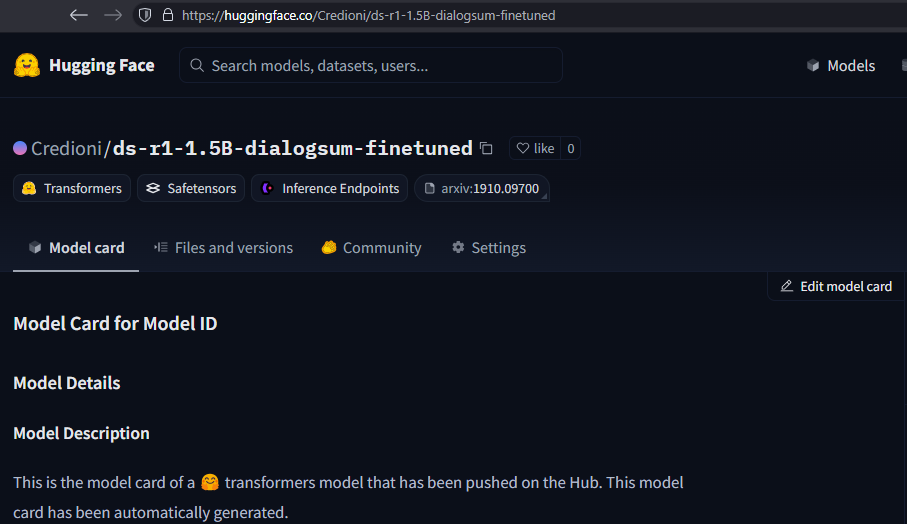

In [3]:
from IPython.display import Image
Image(filename='hf_model_card.png')

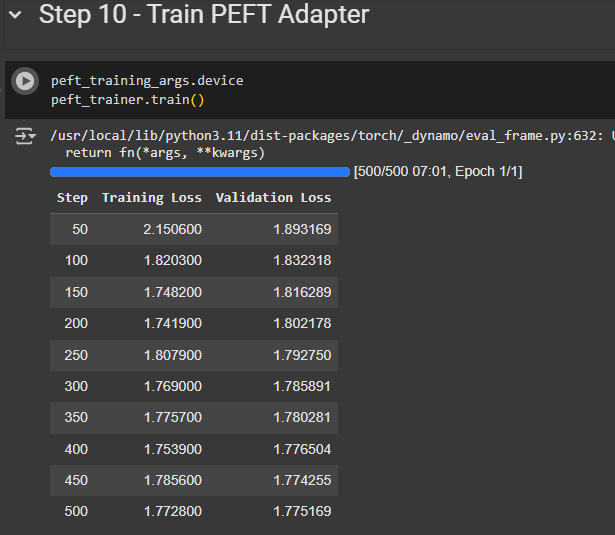

In [4]:
Image(filename='peft_training.png')

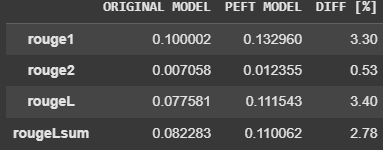

In [5]:
Image(filename='peft_performance.png')